In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional

In [15]:
def plot_amount_distributions(
    *dataframes: pd.DataFrame,
    dataset_names: Optional[List[str]] = None,
    amount_col: str = 'amount',
    label_col: str = 'label',
    log_scale: bool = False,
    figsize: Tuple[int, int] = (12, 6),
    return_stats: bool = True
) -> Tuple[plt.Figure, Optional[pd.DataFrame]]:
    """
    Creates a horizontal box plot comparing amount distributions across multiple datasets.
    
    Parameters:
    -----------
    *dataframes : variable number of pandas DataFrames
        Each DataFrame should contain amount and label columns
    dataset_names : list of str, optional
        Names for each dataset. If None, will use "Dataset 1", "Dataset 2", etc.
    amount_col : str, default='amount'
        Name of the column containing transaction amounts
    label_col : str, default='label'
        Name of the column containing fraud/non-fraud labels
    log_scale : bool, default=False
        Whether to use log scale for amount axis
    figsize : tuple, default=(12, 6)
        Figure size (width, height)
    return_stats : bool, default=True
        Whether to return statistics DataFrame
        
    Returns:
    --------
    fig : matplotlib figure
        The generated figure
    stats_df : pandas DataFrame, optional
        Summary statistics for each dataset and label combination
    """
    # Validate and prepare data
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    
    if len(dataset_names) != len(dataframes):
        raise ValueError("Number of dataset names must match number of dataframes")

    # Prepare data for plotting
    plot_data = []
    stats_data = []
    
    for df, name in zip(dataframes, dataset_names):
        for label in sorted(df[label_col].unique()):
            mask = df[label_col] == label
            subset = df[mask][amount_col]
            
            # Prepare plot data
            plot_data.append({
                'amounts': subset,
                'dataset': name,
                'label': f'{"Bad" if label else "Good"}'
            })
            
            # Calculate statistics
            stats = subset.describe(percentiles=[.25, .75])
            stats_data.append({
                'Dataset-Label': f'{name}-{"Bad" if label else "Good"}',
                'Count': len(subset),
                'Mean': stats['mean'],
                'Median': stats['50%'],
                'Std': stats['std'],
                'Min': stats['min'],
                '25%': stats['25%'],
                '75%': stats['75%'],
                'Max': stats['max'],
                'Outliers%': (len(subset[subset > stats['75%'] + 1.5*(stats['75%'] - stats['25%'])]) +
                             len(subset[subset < stats['25%'] - 1.5*(stats['75%'] - stats['25%'])])) / len(subset) * 100
            })

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot boxes
    positions = np.arange(len(plot_data))
    boxes = []
    
    for i, data in enumerate(plot_data):
        box = ax.boxplot(data['amounts'], 
                        positions=[i],
                        vert=False,
                        patch_artist=True)
        
        # Style based on Good/Bad
        color = 'lightcoral' if data['label'] == 'Bad' else 'lightgreen'
        box['boxes'][0].set_facecolor(color)
        boxes.append(box)
    
    # Add dataset separation lines
    for i in range(len(dataframes)-1):
        pos = (i + 1) * 2 - 0.5
        ax.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)

    # Customize plot
    ax.set_title('Transaction Amount Distribution by Dataset and Label')
    ax.set_xlabel('Amount')
    if log_scale:
        ax.set_xscale('log')
    
    # Set y-axis labels
    ax.set_yticks(positions)
    ax.set_yticklabels([f"{d['dataset']}\n{d['label']}" for d in plot_data])
    
    # Create statistics DataFrame
    stats_df = pd.DataFrame(stats_data).set_index('Dataset-Label') if return_stats else None
    
    plt.tight_layout()
    return fig, stats_df

def plot_amount_distributions_with_outliers(
    *dataframes: pd.DataFrame,
    dataset_names: Optional[List[str]] = None,
    amount_col: str = 'amount',
    label_col: str = 'label',
    figsize: Tuple[int, int] = (15, 10),
    percentile_range: Tuple[int, int] = (1, 99),
    return_stats: bool = True
):
    """Modified version with improved visualization"""
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1], gridspec_kw={'hspace': 0.3})
    
    # Define colors
    colors = {'Good': '#2ecc71', 'Bad': '#e74c3c'}  # Stronger colors
    
    # Prepare data
    plot_data = []
    stats_data = []
    
    for df, name in zip(dataframes, dataset_names):
        for label in sorted(df[label_col].unique()):
            mask = df[label_col] == label
            subset = df[mask][amount_col]
            
            # Calculate percentile bounds
            lower = np.percentile(subset, percentile_range[0])
            upper = np.percentile(subset, percentile_range[1])
            
            # Split data
            main_data = subset[(subset >= lower) & (subset <= upper)]
            outliers = subset[(subset < lower) | (subset > upper)]
            
            label_str = 'Good' if label == 0 else 'Bad'
            plot_data.append({
                'amounts': main_data,
                'outliers': outliers,
                'dataset': name,
                'label': label_str,
                'color': colors[label_str]
            })
            
            # Calculate statistics
            stats = subset.describe(percentiles=[.25, .75])
            stats_data.append({
                'Dataset-Label': f'{name}-{label_str}',
                'Count': len(subset),
                'Mean': stats['mean'],
                'Median': stats['50%'],
                'Std': stats['std'],
                'Min': stats['min'],
                '25%': stats['25%'],
                '75%': stats['75%'],
                'Max': stats['max'],
                'Outliers%': len(outliers) / len(subset) * 100
            })
    
    # Plot main distributions
    positions = np.arange(len(plot_data))
    
    # Main boxplot
    for i, data in enumerate(plot_data):
        box = ax1.boxplot(data['amounts'],
                         positions=[i],
                         vert=False,
                         patch_artist=True,
                         widths=0.7,
                         medianprops={'color': 'black', 'linewidth': 1.5},
                         flierprops={'marker': 'o', 'markerfacecolor': data['color'], 'alpha': 0.7})
        
        # Color the boxes
        plt.setp(box['boxes'], facecolor=data['color'], alpha=0.6)
        plt.setp(box['whiskers'], color=data['color'])
        plt.setp(box['caps'], color=data['color'])
    
    # Outliers plot
    for i, data in enumerate(plot_data):
        if len(data['outliers']) > 0:
            ax2.scatter(data['outliers'],
                       [i] * len(data['outliers']),
                       c=data['color'],
                       alpha=0.7,
                       s=100,  # Larger dots
                       label=f"{data['dataset']} {data['label']}")
    
    # Add dataset separation lines
    for i in range(len(dataframes)-1):
        pos = (i + 1) * 2 - 0.5
        ax1.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)
        ax2.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plots
    ax1.set_title(f'Transaction Amount Distribution ({percentile_range[0]}-{percentile_range[1]} percentile)', 
                  pad=20, fontsize=12)
    ax2.set_title('Outliers Distribution', pad=20, fontsize=12)
    
    # Set labels and ticks
    for ax in [ax1, ax2]:
        ax.set_xlabel('Amount', fontsize=10)
        ax.set_yticks(positions)
        ax.set_yticklabels([f"{d['dataset']}\n{d['label']}" for d in plot_data], 
                          fontsize=10)
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Add legend to outliers plot
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    # Create statistics DataFrame
    stats_df = pd.DataFrame(stats_data).set_index('Dataset-Label') if return_stats else None
    
    return fig, stats_df

               Count          Mean  Median            Std     Min     25%  \
Dataset-Label                                                               
Training-Good      3    200.000000   200.0     100.000000   100.0   150.0   
Training-Bad       3  35333.333333  5000.0   56038.677120  1000.0  3000.0   
Test-Good          3    250.000000   250.0     100.000000   150.0   200.0   
Test-Bad           3  69333.333333  6000.0  113178.325369  2000.0  4000.0   

                    75%       Max  Outliers%  
Dataset-Label                                 
Training-Good     250.0     300.0        0.0  
Training-Bad    52500.0  100000.0        0.0  
Test-Good         300.0     350.0        0.0  
Test-Bad       103000.0  200000.0        0.0  


/var/folders/xz/h_zj3gks34b1t1n1rcq1v6qh0000gn/T/ipykernel_95462/2394492515.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


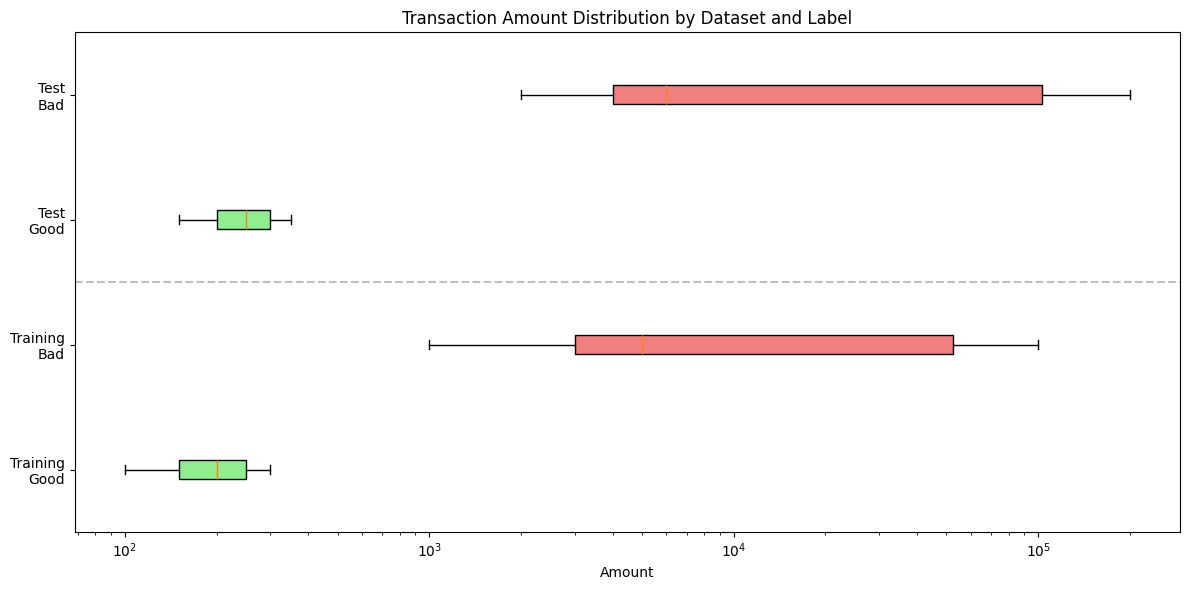

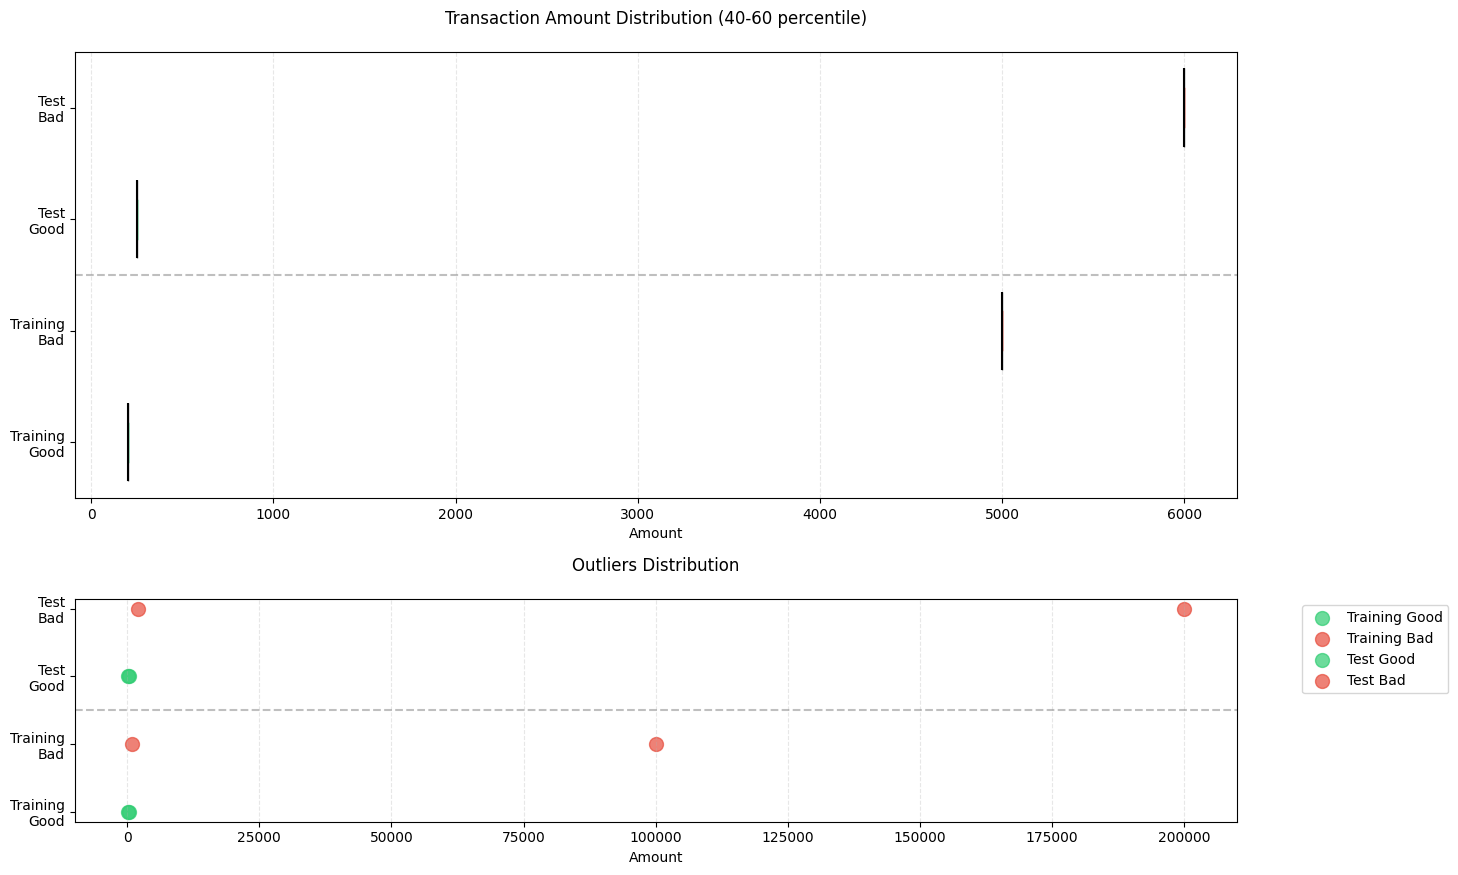

In [16]:
# Test Code:
# Example usage
df1 = pd.DataFrame({
    'amount': [100, 200, 300, 1000, 5000, 100000],
    'label': [0, 0, 0, 1, 1, 1]  # 0 for good, 1 for bad
})

df2 = pd.DataFrame({
    'amount': [150, 250, 350, 2000, 6000, 200000],
    'label': [0, 0, 0, 1, 1, 1]
})

# For regular box plot
fig1, stats1 = plot_amount_distributions(
    df1, df2,
    dataset_names=['Training', 'Test'],
    log_scale=True
)

# For box plot with separate outliers visualization
fig2, stats2 = plot_amount_distributions_with_outliers(
    df1, df2,
    dataset_names=['Training', 'Test'],
    percentile_range=(40,60)
)

# Display statistics
print(stats1)  # or stats2